In [1]:
import os
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb1
from xgboost.sklearn import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import *
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
# to make this notebook's output stable across runs
np.random.seed(666)

In [2]:
_data = pd.read_csv(r'D:\文档\kaggle\coding\数据科学-datawhale\data.csv',engine='python') #4754*90
data = _data.copy()

In [3]:
(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 90 columns):
Unnamed: 0                                    4754 non-null int64
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility

In [4]:
#第一列没有列名,且为index项,删除
data.drop([data.columns[0]], axis=1, inplace=True)


In [5]:
#统计每列的缺失值个数, 并对其进行降序排列
data.isnull().sum().sort_values(ascending=False)

student_feature                               2998
cross_consume_count_last_1_month               426
query_org_count                                304
query_cash_count                               304
latest_six_month_apply                         304
latest_three_month_apply                       304
latest_query_time                              304
query_sum_count                                304
latest_one_month_apply                         304
query_finance_count                            304
apply_credibility                              304
apply_score                                    304
latest_query_day                               304
latest_one_month_loan                          297
loans_score                                    297
loans_credibility_behavior                     297
loans_count                                    297
loans_settle_count                             297
loans_overdue_count                            297
loans_org_count_behavior       

In [6]:
#'student_feature' 这列考虑删除, 或者将NA以0填充
data[['student_feature', 'status']].groupby(data['status']).count()

,student_feature,status
status,,
0,1307,3561
1,449,1193


In [7]:
#根据上面显示student_feature,应该与status是非常弱相关.所以删除,corr可以查看
data.drop(['student_feature'], axis=1, inplace=True)
#数据NA具有同一数据性,比如上面有大量297 304NA数据,他们也通常出自于相同也数据,也就是
#大量304NA数据出自于304个数据

In [8]:
#先自主浏览一下csv文件 肉眼识别需要删除文件
#1.查找所有dtype为object的列, 看是否需要删除
for i in range(len(data.columns)):
    if (data[data.columns[i]]).dtype == 'object':
        print(data.columns[i])

trade_no
bank_card_no
reg_preference_for_trad
source
id_name
latest_query_time
loans_latest_time


In [9]:
#删除不需要的列,object剩余trade_no, reg_preference_for_trad,latest_query_time,loans_latest_time
columns_delete = ['bank_card_no', 'source', 'id_name', 'custid']
data.drop(columns_delete, axis=1, inplace=True)

In [10]:
#有级别含义才需要labelencoder,否则使用onehot
print(data['reg_preference_for_trad'].unique())
data['reg_preference_for_trad'].value_counts()#使用onehot编码 4754个数据,含有两个NA数据

['一线城市' '三线城市' '境外' '二线城市' '其他城市' nan]


一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [11]:
#处理缺失值,用众数填充 mode()[0]!!!!
data['reg_preference_for_trad'].fillna(data['reg_preference_for_trad'].mode()[0],inplace = True)
data['reg_preference_for_trad'].value_counts()

一线城市    3405
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [12]:
#使用onehot编码 4754个数据
data = data.join(pd.get_dummies(data['reg_preference_for_trad']))
data.drop(['reg_preference_for_trad'],axis = 1,inplace = True)

In [13]:
#将object修改为float
data['trade_no'] = data['trade_no'].astype(float)

In [14]:
#将时间序列object 修改为 时间序列
data['latest_query_time'] = pd.to_datetime(data['latest_query_time'], format='%Y-%m-%d %H:%M:%S.%f')
data['loans_latest_time'] = pd.to_datetime(data['loans_latest_time'], format='%Y-%m-%d %H:%M:%S.%f')

In [15]:
#将时间序列 修改为int
import datetime
a = (datetime.datetime.today() - data['loans_latest_time'])
b = map(lambda a:a.days, a)
data['loans_latest_time'] = pd.Series(b)


a = (datetime.datetime.today() - data['latest_query_time'])
b = map(lambda a:a.days, a)
data['latest_query_time'] = pd.Series(b)


In [16]:
#筛选无关特征，相关系数
corr=data.corr()
corr_1=np.abs(corr['status'])
corr_1.sort_values(ascending=False)

status                                     1.000000
trans_fail_top_count_enum_last_1_month     0.332256
history_fail_fee                           0.320033
loans_overdue_count                        0.279125
loans_score                                0.259092
latest_one_month_fail                      0.257269
apply_score                                0.244200
rank_trad_1_month                          0.147258
latest_one_month_suc                       0.138144
trans_fail_top_count_enum_last_6_month     0.133477
trans_fail_top_count_enum_last_12_month    0.117161
top_trans_count_last_1_month               0.117113
consfin_avg_limit                          0.091101
consfin_credit_limit                       0.083844
trans_day_last_12_month                    0.078892
avg_price_top_last_12_valid_month          0.071874
trans_top_time_last_1_month                0.068591
consume_top_time_last_1_month              0.066371
consfin_max_limit                          0.063307
latest_six_m

In [17]:
#trade_no 弱相关 剔除
data.drop(['trade_no'],axis = 1,inplace = True)

In [18]:
#统计每列的缺失值个数, 并对其进行降序排列 用keys获取列名
data.isnull().sum().sort_values(ascending=False)[:5]

cross_consume_count_last_1_month    426
query_org_count                     304
query_cash_count                    304
latest_six_month_apply              304
latest_one_month_apply              304
dtype: int64

In [19]:
#针对有缺失值的列看其相关性,相关性低,删除列
corr_1.sort_values(ascending=False)[data.isnull().sum().sort_values(ascending=False).keys()[:43]].sort_values(ascending=False)

history_fail_fee                     0.320033
loans_overdue_count                  0.279125
loans_score                          0.259092
latest_one_month_fail                0.257269
apply_score                          0.244200
latest_one_month_suc                 0.138144
consfin_avg_limit                    0.091101
consfin_credit_limit                 0.083844
avg_price_top_last_12_valid_month    0.071874
consfin_max_limit                    0.063307
latest_six_month_loan                0.062565
latest_query_time                    0.059539
latest_query_day                     0.059274
query_cash_count                     0.054786
latest_three_month_loan              0.053082
loans_count                          0.048211
consfin_product_count                0.035339
consfin_org_count_current            0.032000
consfin_org_count_behavior           0.032000
history_suc_fee                      0.030332
latest_one_month_loan                0.030005
loans_org_count_behavior          

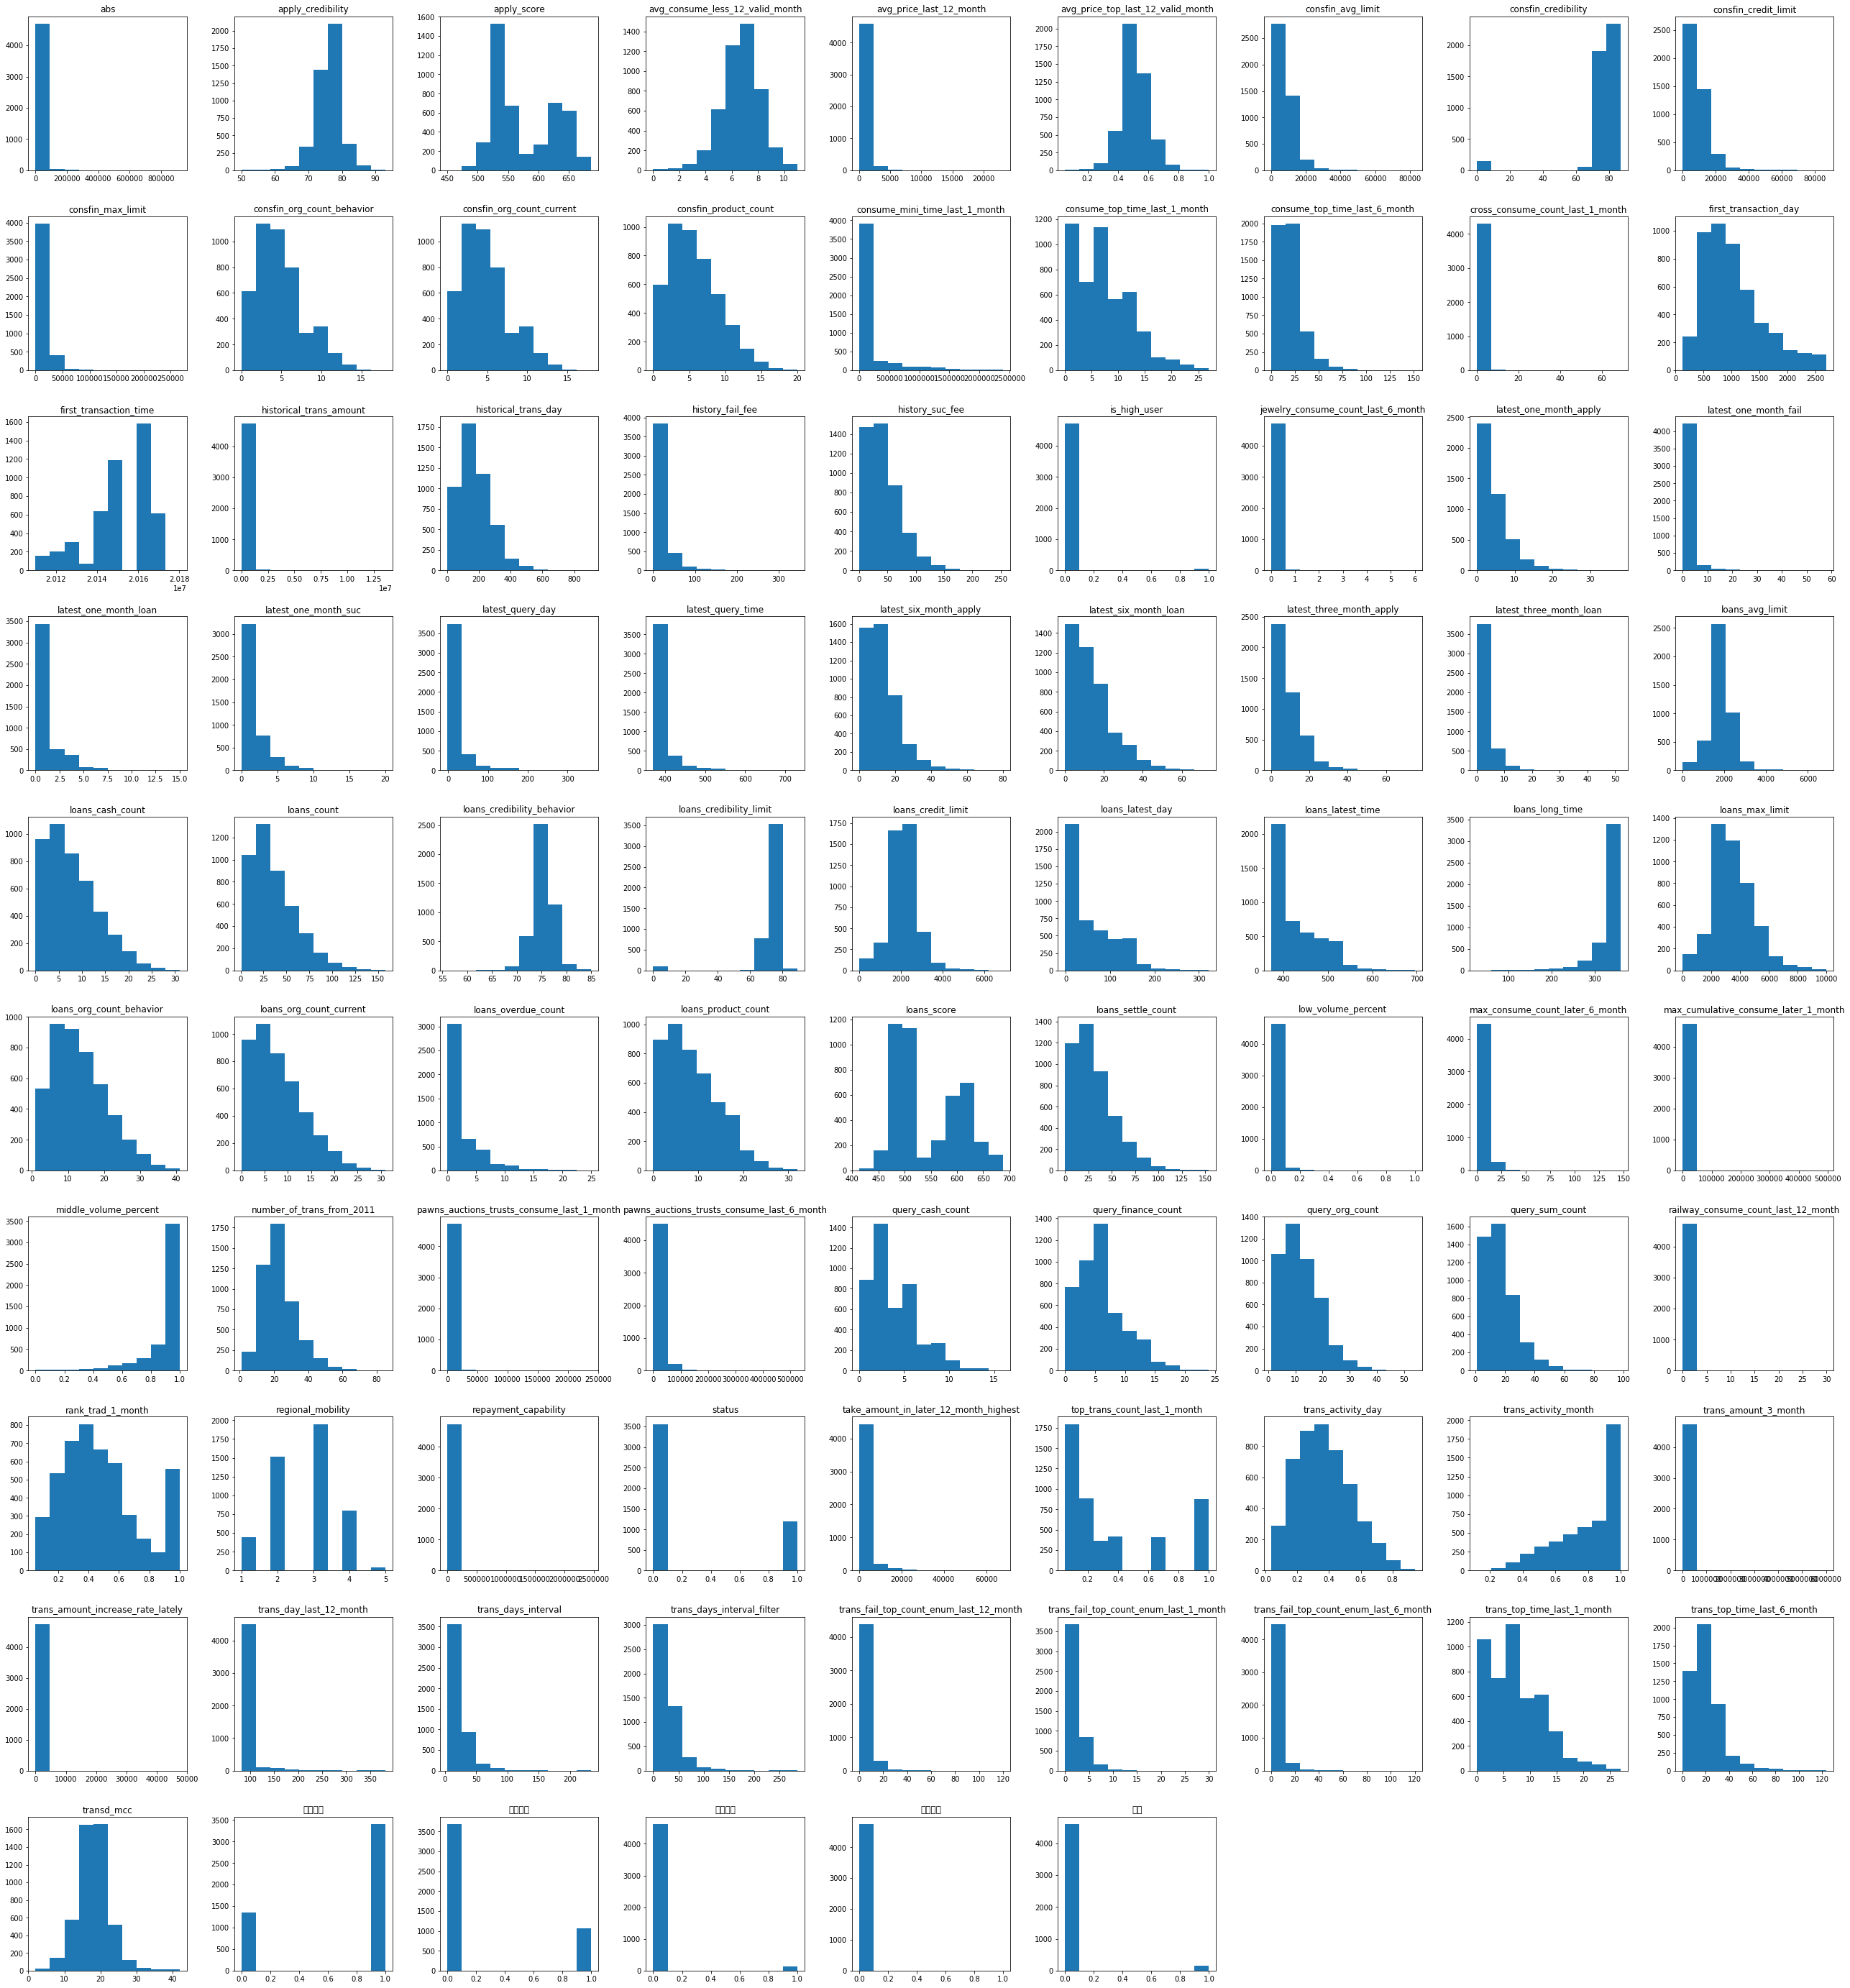

In [20]:
#查看数据分布, 偏态分布  不适合均值填充
data.hist(figsize=(45, 50), grid=False)
plt.show()

In [21]:
#用中值进行填充,由于特征太多后面还是建议删除弱相关特征,暂时先不操作,且感觉用中值填充也不太好

for i in data.keys():
    data[i].fillna(data[i].median(), inplace=True)
data.isnull().sum().sort_values(ascending=False)

境外                                            0
consume_mini_time_last_1_month                0
trans_top_time_last_1_month                   0
trans_top_time_last_6_month                   0
consume_top_time_last_1_month                 0
consume_top_time_last_6_month                 0
cross_consume_count_last_1_month              0
trans_fail_top_count_enum_last_1_month        0
trans_fail_top_count_enum_last_6_month        0
trans_fail_top_count_enum_last_12_month       0
max_cumulative_consume_later_1_month          0
avg_price_last_12_month                       0
max_consume_count_later_6_month               0
railway_consume_count_last_12_month           0
pawns_auctions_trusts_consume_last_1_month    0
pawns_auctions_trusts_consume_last_6_month    0
jewelry_consume_count_last_6_month            0
status                                        0
first_transaction_day                         0
trans_day_last_12_month                       0
avg_price_top_last_12_valid_month       

In [25]:
y = data['status']
data.drop(['status'], axis=1, inplace=True)
x = data

In [30]:
from sklearn.model_selection import *
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=666, stratify=np.array(y))

d:\python\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

